In [2]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2
import cmasher as cmr

Defining the path to the fluorescence backfill images, pressures used, etc.:

In [36]:
try:
    common_folder_path = r"/Volumes/dfs/DAQ/Atomic and Laser/Hooker/TWLab/Data/2025-02-06_fluorescence_Seb/steep_axicon_scan1/" #common portion of the path to the fluorescence scan images
    bg_shotlist = glob.glob(common_folder_path + r"bg/*" + 'tif' + r"*") #list of all the background images in the folder
    if len(bg_shotlist) == 0:
        raise FileNotFoundError("Path not found!")
except FileNotFoundError:
    print("Path not found!")  

print(bg_shotlist) #check that the background images were found

#list of the backfill pressures used in the scan
pressures = [10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46,48,50,52,54,56,58,60,62,64,66,68,70,72,74,90,92,94,96,98,100]
#pressures=[10]    
print(f"Pressures: {pressures}")

['/Volumes/dfs/DAQ/Atomic and Laser/Hooker/TWLab/Data/2025-02-06_fluorescence_Seb/steep_axicon_scan1/bg/ser1_X1.tif', '/Volumes/dfs/DAQ/Atomic and Laser/Hooker/TWLab/Data/2025-02-06_fluorescence_Seb/steep_axicon_scan1/bg/ser1_X10.tif', '/Volumes/dfs/DAQ/Atomic and Laser/Hooker/TWLab/Data/2025-02-06_fluorescence_Seb/steep_axicon_scan1/bg/ser1_X2.tif', '/Volumes/dfs/DAQ/Atomic and Laser/Hooker/TWLab/Data/2025-02-06_fluorescence_Seb/steep_axicon_scan1/bg/ser1_X3.tif', '/Volumes/dfs/DAQ/Atomic and Laser/Hooker/TWLab/Data/2025-02-06_fluorescence_Seb/steep_axicon_scan1/bg/ser1_X4.tif', '/Volumes/dfs/DAQ/Atomic and Laser/Hooker/TWLab/Data/2025-02-06_fluorescence_Seb/steep_axicon_scan1/bg/ser1_X5.tif', '/Volumes/dfs/DAQ/Atomic and Laser/Hooker/TWLab/Data/2025-02-06_fluorescence_Seb/steep_axicon_scan1/bg/ser1_X6.tif', '/Volumes/dfs/DAQ/Atomic and Laser/Hooker/TWLab/Data/2025-02-06_fluorescence_Seb/steep_axicon_scan1/bg/ser1_X7.tif', '/Volumes/dfs/DAQ/Atomic and Laser/Hooker/TWLab/Data/2025-02-0

Defining the functions used to load the images, average them, subtract background, pick the ROI (lineout) of the plasma fluorescence, and find the output fluorescence:

In [37]:
avg_sigs = np.zeros(len(pressures)) #initialize an array to store the average signals

def load_and_calculate_average(filenames):  ## Function to load and average the images
    total_sum = None # Initialize an empty array to store pixel values
    for filename in filenames: # Iterate over each filename
        image = cv2.imread(filename, -1) # Load the image , -1 to load the image as is
        if total_sum is None: # If this is the first image, initialize total_sum with zeros
            total_sum = np.zeros_like(image, dtype=np.uint64) # Initialize an empty array to store pixel values, unit64 to avoid overflow
        total_sum += image.astype(np.uint64) # Add the pixel values of the current image to the total_sum, unit64 to avoid overflow
    if total_sum is None: # If no images were loaded, return None
        return None
    else:
        average_image = total_sum / len(filenames) # Calculate the average image by dividing the total sum by the number of images
        average_image.astype(image.dtype) # Convert the average image to the same data type as the input images

    return average_image

## Function to get the average signal from the fluorescence camera
# allows you to zoom in on the lineout, pick the region for averaging the fluorescence along a line, and the region for averaging the signal
def get_avg_signal_angled(shotlist: list[str], ## List of filenames of the images to be averaged
                          bg_shotlist: list[str], ## List of filenames of the background images to be averaged
                          coords_start: list[int] = [50, 50], ## Coordinates of the start of the lineout (x,y)
                          coords_stop: list[int] = [500, 500], ## Coordinates of the end of the lineout (x,y)
                          plot_flag: bool = True, ## Flag to plot the image and lineout (turn off for batch processing, after you're confident in the fluorescence ROI)
                          title: str = "Fluorescence camera angled", ## Title of the plot
                          max_pixel_value: int or str = 2**16, ## Maximum pixel value for the colormap
                          line_start_x: int = 0, ## Start of the lineout (simply start xlim for the lineout plot)
                          line_stop_x: int = 500, ## End of the lineout (simply end xlim for the lineout plot)
                          average_start_x: int = 0, ## Start of the region to average the signal over
                          average_stop_x: int = 500, ## End of the region to average the signal over
                          number_of_line_averages: int = 5, ## Number of lineouts around the main line to average over (1 = 3 lines)
                          x_min_zoom: int = 0, ## Zoom section of the window
                          x_max_zoom: int = 600,
                          y_min_zoom: int = 0,
                          y_max_zoom: int = 600):
    
    x_start = coords_start[0]
    y_start = coords_start[1]
    x_stop = coords_stop[0]
    y_stop = coords_stop[1]

    line_grad = (y_stop - y_start) / (x_stop - x_start) ## Gradient of the line
    line_intercept = y_start - line_grad * x_start ## Intercept of the line with the y-axis (coordinate system defined by the camera)
    
    if len(shotlist) == 0: ## If no images found, return 0
        return 0
    else:
        average_image = load_and_calculate_average(shotlist) ## Load and average the images
        average_image_bg = load_and_calculate_average(bg_shotlist) ## Load and average the background images
        if average_image_bg is None: ## If no background images found, run without background removal
            print("No background images found, running without background removal...")
            im = average_image
        else:
            im = average_image - average_image_bg ## Background removal (avg image - avg bg image)
            
        im[im<0] = 0 ## Remove negative pixel values
        x_min, x_max = 0, len(im[0]) ## Min and max x values of the image (probably not needed)
        y_min, y_max = 0, len(im) ## Min and max y values of the image (probably not needed)
        
        if str(max_pixel_value) == "auto": ## If max pixel value is set to auto, calculate the max pixel value
            max_pixel_value = np.max(im) ## Max pixel value for the colormap
        
        lneqn = lambda x, m, c: m*x + c     ## Line section for following the plasma channel (y = mx + c)        
        lineoutlist = [] ## List to store the lineouts
        for i in range(-number_of_line_averages, number_of_line_averages, 1): ## Average over a number of lines
            spectra = [] ## List to store the lineouts
            for j in range(x_start, x_stop, 1): ## Iterate over the x values of the line
                y = round(lneqn(j, line_grad, line_intercept+i)) 
                if y > y_max: ## If the line goes out of the image, set the value to the edge of the image
                    y = y_max  
                elif y < 0: ## If the line goes out of the image, set the value to the edge of the image
                    y = 0
                val = im[y][j] ## Get the pixel value at the line
                spectra.append(val) ## Append the pixel value to the lineout list
            lineoutlist.append(spectra) ## Append the lineout to the list of lineouts
            
        lineout = np.mean(lineoutlist, axis=0) ## Average over the lineouts
        avg_sig = np.mean(lineout[average_start_x:average_stop_x]) ## Average over the region of interest (returns a single number)

        if plot_flag: ## If plot flag is set to True, plot the image and lineout
            fig, axs = plt.subplots(1,2, figsize=(12,5))
            axs[0].imshow(im, aspect='auto', origin='lower', vmin=0, vmax=max_pixel_value, cmap=cmr.torch_r) ## Plot the image
            axs[0].scatter([x_start, x_stop], [y_start, y_stop], color='tab:green', s=10) ## Plot the start and stop points of the line
            axs[0].plot([x_start, x_stop], [y_start, y_stop], color='tab:green', linewidth=1, linestyle=(0, (1, 10))) ## Plot the line following the plasma channel in green dots

            axs[0].set_xlim(x_min_zoom, x_max_zoom) ## Zoom in the image
            axs[0].set_ylim(y_min_zoom, y_max_zoom) ## Zoom in the image
            axs[0].set_xlabel('X [pix]')
            axs[0].set_ylabel('Y [pix]')

            axs[1].plot(lineout) ## Plot the lineout
            axs[1].set_xlim(line_start_x, line_stop_x) ## Set the x limits of the lineout plot
            axs[1].set_ylim(0, max_pixel_value) ## Set the y limits of the lineout plot
            
            axs[1].axvline(average_start_x,ls='dotted',color='black') ## Plot the region of interest picked by the user
            axs[1].axvline(average_stop_x,ls='dotted',color='black') ## Plot the region of interest picked by the user
            axs[1].set_title('lineout: avg fluorescence signal')
            axs[1].set_xlabel('loc [pix]')
            axs[1].set_ylabel('avg pixel value')

            axs[1].hlines(y=avg_sig,xmin=average_start_x,xmax=average_stop_x,color='red',ls='dashed') ## Plot the average signal over the region of interest (the final number you're outputting)
            axs[1].text(average_start_x, avg_sig, f'{avg_sig:.0f}', ha='right', va='bottom', color='red')
            
            axs[0].set_title(title)
            
        return avg_sig

Actually using the function to get the average signal from the fluorescence camera, for the backfill part of the scan:

In [38]:
for pressure,i in zip(pressures,range(len(pressures))): ## Iterate over the pressures and calculate the average signal
    shotlist = glob.glob(common_folder_path + str(pressure)+ r"mbar/*tif*") ## List of the images for the current pressure (change this if folder structure is different)
    bg_shotlist = glob.glob(common_folder_path + r"/bg/*tif*") ## List of the background images for the current pressure (change this if folder structure is different)
    if len(shotlist) == 0: ## If no images found, raise an error
        raise FileNotFoundError("Path to shots is not valid, Change!")
    else:
        img = cv2.imread(shotlist[0]) ## Load the first image to get the dimensions
        avg_sigs[i] = get_avg_signal_angled(shotlist,
                                            bg_shotlist,
                                            plot_flag=False,
                                            title=str(pressure) + " mbar",
                                            max_pixel_value="auto",
                                            average_start_x=50, ## Region to average the signal over (denoted by vertical dotten line in the graph below)
                                            average_stop_x=265, ## Region to average the signal over (denoted by vertical dotten line in the graphs below)
                                            coords_start=[295, 150], ## Start of the fluorescence lineout (x,y)
                                            coords_stop=[565, 575]) ## End of the fluorescence lineout (x,y)
print(avg_sigs) ## Print the average signals, for a sanity check

[1479.8515814  1905.0307907  2199.76334884 2458.59060465 2699.64432558
 2543.99116279 3352.72790698 2977.06846512 2903.18418605 3452.82986047
 3639.07246512 3190.206      3640.35195349 3476.99655814 3166.22972093
 3270.42744186 3390.1055814  3390.1055814  4002.1695814  3345.544
 3129.34646512 4072.14306977 3705.45404651 3849.3715814  3180.97134884
 3663.23195349 3743.24474419 4102.50986047 3838.66637209 4196.32246512
 3727.43562791 3408.16153488 3667.53837209 4461.22376744 3453.38693023
 3961.40874419 4153.01530233 4235.0127907  4840.08846512]


Now plot the average fluorescence signal against the backfill hydrogen pressure. 

(0.0, 5000.0)

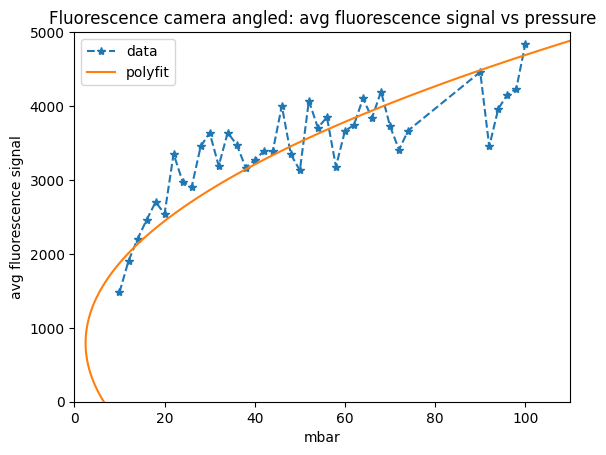

In [192]:
plt.plot(pressures,avg_sigs, '--*',label='data') ## Plot the average signals vs the pressures
plt.xlabel('mbar')
plt.ylabel('avg fluorescence signal')
plt.title('Fluorescence camera angled: avg fluorescence signal vs pressure')
plt.xlim(0,110)

#depending on the data, one may want to choose a simple linear fit, or a polynomial in case of a non-linear relationship
# For the later section, we want have 'mbar per fluorescence signal' value because then we can just multiply the signal by this number, and get the density
# here, however, it makes sense to have the independent variable (backfill pressure) on the x-axis, and the dependent variable (fluorescence signal) on the y-axis because it makes more sense for the plotting
# For this reason, I call 'xfit' the fluorescence signal values, and 'yfit' the backfill pressure values, and then plot the fit as xfit vs yfit

# linear verison of the fit:
mbar_per_sig = np.dot(avg_sigs,pressures) / np.dot(avg_sigs,avg_sigs) ## Fit a line to the data, enforcing the line to go through the origin
xfit = np.linspace(0,1.1*max(avg_sigs),100) ## Create x values to plot the fit
yfit = mbar_per_sig*xfit ## Create a line to plot the fit using the 

#polynomial version of the fit:
coeffs = np.polyfit(avg_sigs,pressures,2) #fit a polynomial of some degree to the data
poly_func = np.poly1d(coeffs) #create a function from the polynomial coefficients

#plt.plot(yfit,xfit,label='polynomial fit')
plt.plot(poly_func(xfit),xfit,label='polyfit') ## Plot the linear fit
plt.legend()
plt.ylim(0,5000)

Here we go to the second half of the scan, looking at fluorescence from the triggered mode of the gas, as opposed to backfill:

In [107]:
iota_delays = [77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95] # actually USED delay times of the iota gas jet [ms] (gives error if the data can't be found)
iota_open_ms = [15] #opening times of the iota gas jet [ms]
iota_BPs = [0.5,0.75,1,2,3] #backing pressures of the iota gas jet [bar] - even if there is only one value, it needs to be in a list + the code is written to handle multiple values, so make up one if there is only one

results_cube = np.zeros((len(iota_delays), len(iota_open_ms), len(iota_BPs))) #create an empty 3D array which will contain the data


for iota_delay,i in zip(iota_delays,range(len(iota_delays))): ## Iterate over the delays of the valve opening
    for iota_open_time, j in zip(iota_open_ms, range(len(iota_open_ms))): #iterate over the opening times (lengths) of the valve
        for iota_BP, k in zip(iota_BPs, range(len(iota_BPs))): #iterate over the used backfill pressures
            shotlist = glob.glob(common_folder_path + '/' +str(iota_BP) +'barBP/jet' + str (iota_open_time)+ "ms/" +str(iota_delay) + r"msdel/*tif*") ## List of the images for the current pressure (change this if folder structure is different)
            p=iota_delays.index(iota_delay) ## Get the index of the current delay
            q=iota_open_ms.index(iota_open_time) ## Get the index of the current open time
            r=iota_BPs.index(iota_BP) ## Get the index of the current backfill pressure
            
            ## Calculate the average signal for the current delay, open time, and backfill pressure, and fill the results "cube"
            results_cube[p,q,r] = get_avg_signal_angled(shotlist,
                                                        bg_shotlist,
                                                        plot_flag=False,
                                                        title=str(iota_delays[p])+" ms delay, "+str(iota_open_ms[q])+" ms open time, "+str(iota_BPs[r])+" bar backing pressure",
                                                        max_pixel_value="auto",
                                                        average_start_x=50, ## Region to average the signal over (denoted by vertical dotten line in the graph below)
                                                        average_stop_x=265, ## Region to average the signal over (denoted by vertical dotten line in the graphs below)
                                                        coords_start=[295, 150], ## Start of the fluorescence lineout (x,y)
                                                        coords_stop=[565, 575]) ## End of the fluorescence lineout (x,y)

Here we put it all together, and show the pressure inside the cell in the triggered regime, using the fluorescence as mapping:

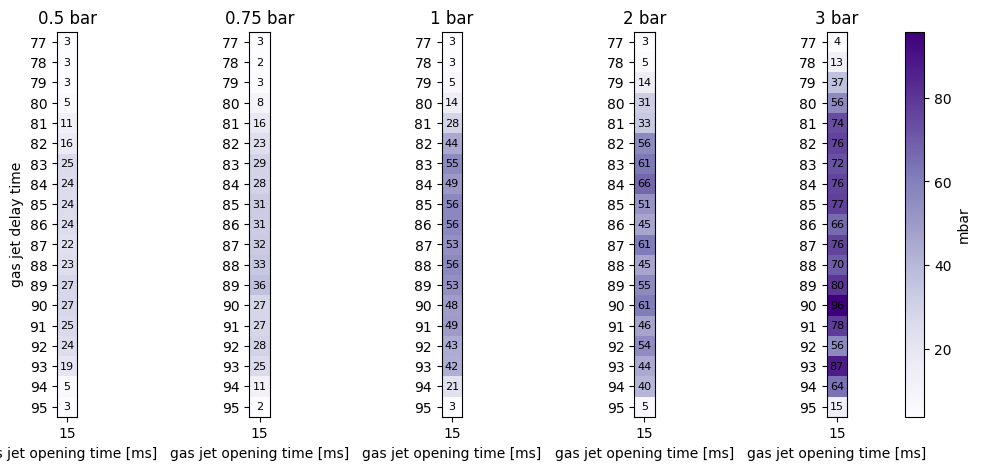

In [193]:
#In this version, I'm using the polynomial fit to get the density values, but you can use the linear fit as well:
array_3d = np.vectorize(poly_func)(results_cube) #multiply the avg fluorescence values in the 3D array by the mbar_per_sig value found previously to get the density values
array_3d=array_3d.clip(min=0) #remove negative values

min_value = np.min(array_3d) #get the minimum value in the 3D array
max_value = np.max(array_3d) #get the maximum value in the 3D array

#here we visualize layers of the 3D array (2D slices, each slice corresponding to one backing pressure)
# Create subplots for each 2D slice of the 3D array:
fig, axs = plt.subplots(1, array_3d.shape[2], figsize=(15, 5))  # Adjust figsize as needed

cmap = "Purples"  # Choose a colormap from https://matplotlib.org/stable/tutorials/colors/colormaps.html
# Plot each 2D slice
for i in range(array_3d.shape[2]): #iterate over the 3rd dimension of the 3D array (valve backing pressures)
    axs[i].imshow(array_3d[:, :, i], cmap=cmap, vmin=min_value, vmax=max_value) # Plot the 2D slice
    axs[i].set_title(f"{iota_BPs[i]} bar") # Set the title of the subplot to the current backing pressure
    # Add text annotations
    for y in range(array_3d.shape[0]): #iterate over the 1st dimension of the 3D array (valve delays)
        for x in range(array_3d.shape[1]): #iterate over the 2nd dimension of the 3D array (valve opening times)
            if array_3d[y, x, i] > 0.1: #only annotate values above a certain threshold
                axs[i].text(x, y, f'{array_3d[y, x, i]:.0f}', color='black', ha='center', va='center',fontsize=8) # add text (mbar values) annotations to the plot
    

    axs[i].set_xticks(np.arange(array_3d.shape[1])) #set the xticks to the number of valve opening times
    axs[i].set_xticklabels(iota_open_ms) #set the xtick labels to the valve opening times
    axs[i].set_yticks(np.arange(array_3d.shape[0])) #set the yticks to the number of valve delays
    axs[i].set_yticklabels(iota_delays) #set the ytick labels to the valve delays

    axs[i].set_xlabel('gas jet opening time [ms]') 

axs[0].set_ylabel('gas jet delay time')
# Add color bar
cbar = fig.colorbar(axs[-1].imshow(array_3d[:, :, -1], cmap=cmap), ax=axs.ravel().tolist())
cbar.set_label('mbar')


Text(0.5, 0, 'time since valve open! trigger [ms]')

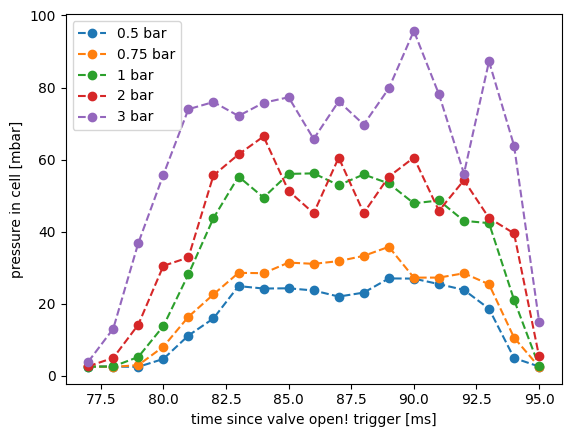

In [197]:
t_laser = 101 #laser arrives at this timing
iota_delays=np.array(iota_delays)
plt.plot(iota_delays,array_3d[:,:,0],'--o',label='0.5 bar')
plt.plot(iota_delays,array_3d[:,:,1],'--o',label='0.75 bar')
plt.plot(iota_delays,array_3d[:,:,2],'--o',label='1 bar')
plt.plot(iota_delays,array_3d[:,:,3],'--o',label='2 bar')
plt.plot(iota_delays,array_3d[:,:,4],'--o',label='3 bar')
#plt.axvline(x=17,color='black',ls='dotted')

plt.ylabel('pressure in cell [mbar]')

plt.legend()
#plt.xlim(0,25)
plt.xlabel('time since valve open! trigger [ms]')